# ALS sample analysis

In [9]:
config = {
    'entity': 'ejmockler',
    'project': 'ALS-NUPS-2000',
    'crossValIterations': 10
}

In [10]:
import pandas as pd
import os
import multiprocess as multiprocessing

## Local tracking

In [11]:
import os
from traceback import print_exc
import pandas as pd

print(os.getcwd())
bootstrapDir = f"../src/{config['project']}/bootstraps"
bootstraps = [int(name) for name in os.listdir(bootstrapDir)]

sampleResults = pd.DataFrame()

def processBootstrapIterationResult(bootstrap):
    currentResults = pd.DataFrame()
    modelFolders = os.listdir(f"{bootstrapDir}/{bootstrap}")
    for modelFolder in modelFolders:
        bootstrapDict = {}
        try:
            currentFiles = os.listdir(f"{bootstrapDir}/{bootstrap}/{modelFolder}")
            bootstrapDict['probability'] = pd.read_csv(f"{bootstrapDir}/{bootstrap}/{modelFolder}/sampleResults.csv")
            bootstrapDict['labels'] = pd.concat([
                pd.read_csv(f"{bootstrapDir}/{bootstrap}/{modelFolder}/testLabels/{k+1}.csv") for k in range(config['crossValIterations'])]).set_index('id', drop=True)
            sampleResultsBootstrapDF = bootstrapDict['labels'].merge(bootstrapDict['probability'], left_index=True, right_on='id')
            sampleResultsBootstrapDF['bootstrap'] = bootstrap
            sampleResultsBootstrapDF['model'] = modelFolder
            currentResults = pd.concat([currentResults, sampleResultsBootstrapDF], ignore_index=False)
        except Exception:
            print_exc()
            break  # greedily collect data from as many completed bootstraps as possible
    return currentResults

with multiprocessing.Pool(os.cpu_count()) as p:
    sampleResults =  pd.concat(p.map(processBootstrapIterationResult, bootstraps), ignore_index=False)


/home/noot/Desktop/machine-learning-als-genomics/notebook


In [12]:
print(f"completed bootstraps: {len(sampleResults['bootstrap'].unique())}")

completed bootstraps: 2000


## Plot model logits

In [13]:
import plotly.express as px

# Group by sample ID and calculate mean probability for each sample
mean_probs = sampleResults.groupby(['id', 'model', 'testLabel'])['probability'].mean().reset_index()

# Create histogram
fig = px.histogram(mean_probs, x='probability', color='testLabel', title="Mean Sample ALS Probability")
fig.show()

## Determine sample accuracy

In [14]:
import numpy as np
import pandas as pd

# calculate accuracy for each sample, model pair
resolvedSampleResults = []
for id, group in sampleResults.groupby(['id', 'model'], group_keys=False):
    assert len(group['testLabel'].unique()) == 1  # All labels should be the same
    sampleLabel = group['testLabel'].unique()[0]
    sampleClassifications = np.around(group['probability']) # Scale probablility to label values for direct classification
    group['accuracy'] = np.mean(sampleClassifications == sampleLabel)
    resolvedSampleResults.append(group) 
    
sampleResults = pd.concat(resolvedSampleResults)
sampleResults_cases = sampleResults[sampleResults['testLabel'] == 1]
sampleResults_controls = sampleResults[sampleResults['testLabel'] == 0]


In [15]:
pd.set_option('display.max_rows', 25)
pd.set_option('display.min_rows', 25)

In [16]:
sampleResults[[column for column in sampleResults.columns if column not in ['shapExplanations']]]['accuracy'].describe()

count    1.915200e+07
mean     5.082705e-01
std      3.180449e-01
min      0.000000e+00
25%      2.146051e-01
50%      5.175000e-01
75%      8.055000e-01
max      1.000000e+00
Name: accuracy, dtype: float64

In [17]:
import plotly.express as px

# Group by sample ID and label, calculate mean accuracy for each sample
mean_accuracy = sampleResults.loc[sampleResults['model']=='LinearSVC'].groupby(['id', 'testLabel'])['accuracy'].mean().reset_index()

# Create histogram of mean accuracy
fig = px.histogram(mean_accuracy, x='accuracy', color='testLabel', pattern_shape='testLabel', title="Mean Sample Accuracy")
fig.show()

## Select outlier samples in accuracy distribution

In [18]:
accuracyThreshold = (0.975, 0.025)
accurateSamples = sampleResults[sampleResults['accuracy'] >= accuracyThreshold[0]].groupby(['id', 'testLabel'])['accuracy'].mean().reset_index()
discordantSamples = sampleResults[sampleResults['accuracy'] <= accuracyThreshold[1]].groupby(['id', 'testLabel'])['accuracy'].mean().reset_index()

In [19]:
accurateCases = accurateSamples.loc[accurateSamples['testLabel'] == 1,'id']
discordantCases = discordantSamples.loc[discordantSamples['testLabel'] == 1,'id']

In [20]:
print(f"total samples: {sampleResults['id'].unique().shape[0]}")
print(f"cases with classification accuracy above {accuracyThreshold[0]:.0%}: {accurateCases.unique().shape[0]}")
print(f"controls with classification accuracy above {accuracyThreshold[0]:.0%}: {accurateSamples.loc[accurateSamples['testLabel'] == 0,'id'].unique().shape[0]}")

print(f"cases with classification accuracy above {accuracyThreshold[1]:.0%}: {discordantCases.unique().shape[0]}")
print(f"controls with classification accuracy above {accuracyThreshold[1]:.0%}: {discordantSamples.loc[discordantSamples['testLabel'] == 0,'id'].unique().shape[0]}")

total samples: 2736
cases with classification accuracy above 98%: 400
controls with classification accuracy above 98%: 124
cases with classification accuracy above 2%: 318
controls with classification accuracy above 2%: 115


In [21]:
accurateSamples.to_csv(f"{config['project']}__accurateSamples_{accuracyThreshold[0]:.1%}.csv", sep='\t', index=False)
discordantSamples.to_csv(f"{config['project']}__discordantSamples_{accuracyThreshold[1]:.1%}.csv", sep='\t', index=False)

In [47]:
accurateCases.to_csv(f"{config['project']}__accurateCases.csv", sep='\t', index=False)
discordantCases.to_csv(f"{config['project']}__discordantCases.csv", sep='\t', index=False)

## Correlate sample accuracy & probability across models

- Use Spearman rank-order method since model accuracies/logits should be monotonic

In [ ]:
accuracy_grouped_models_df = sampleResults.groupby(['id', 'model', 'testLabel'])['accuracy'].mean().reset_index()

In [ ]:
probability_grouped_models_df = sampleResults.groupby(['id', 'model', 'testLabel'])['probability'].mean().reset_index()

In [ ]:
accuracy_grouped_models_df

In [ ]:
model_case_accuracy_pivot_df = accuracy_grouped_models_df.loc[accuracy_grouped_models_df['testLabel']==1].pivot(index='id', columns='model', values='accuracy')
model_control_accuracy_pivot_df = accuracy_grouped_models_df.loc[accuracy_grouped_models_df['testLabel']==0].pivot(index='id', columns='model', values='accuracy')

In [ ]:
model_case_probability_pivot_df = probability_grouped_models_df.loc[probability_grouped_models_df['testLabel']==1].pivot(index='id', columns='model', values='probability')
model_control_probability_pivot_df = probability_grouped_models_df.loc[probability_grouped_models_df['testLabel']==0].pivot(index='id', columns='model', values='probability')

In [ ]:
model_control_accuracy_pivot_df

In [ ]:
from scipy.stats import spearmanr

model_accuracy_pivot_df = pd.concat([model_case_accuracy_pivot_df, model_control_accuracy_pivot_df], axis=0)
modelAccuracyCorrelation, _ = spearmanr(model_accuracy_pivot_df)
modelAccuracyCorrelation_df = pd.DataFrame(modelAccuracyCorrelation, index=model_accuracy_pivot_df.columns, columns=model_accuracy_pivot_df.columns)

modelCaseAccuracyCorrelation, _ = spearmanr(model_case_accuracy_pivot_df)
modelCaseAccuracyCorrelation_df =  pd.DataFrame(modelCaseAccuracyCorrelation, index=model_case_accuracy_pivot_df.columns, columns=model_case_accuracy_pivot_df.columns)
modelControlAccuracyCorrelation, _ = spearmanr(model_control_accuracy_pivot_df)
modelControlAccuracyCorrelation_df =  pd.DataFrame(modelControlAccuracyCorrelation, index=model_control_accuracy_pivot_df.columns, columns=model_control_accuracy_pivot_df.columns)

In [ ]:
from scipy.stats import spearmanr

model_probability_pivot_df = pd.concat([model_case_probability_pivot_df, model_control_probability_pivot_df], axis=0)
modelProbabilityCorrelation, _ = spearmanr(model_probability_pivot_df)
modelProbabilityCorrelation_df = pd.DataFrame(modelProbabilityCorrelation, index=model_probability_pivot_df.columns, columns=model_probability_pivot_df.columns)

modelCaseProbabilityCorrelation, _ = spearmanr(model_case_probability_pivot_df)
modelCaseProbabilityCorrelation_df =  pd.DataFrame(modelCaseProbabilityCorrelation, index=model_case_probability_pivot_df.columns, columns=model_case_probability_pivot_df.columns)
modelControlProbabilityCorrelation, _ = spearmanr(model_control_probability_pivot_df)
modelControlProbabilityCorrelation_df =  pd.DataFrame(modelControlProbabilityCorrelation, index=model_control_probability_pivot_df.columns, columns=model_control_probability_pivot_df.columns)

In [23]:
import plotly.figure_factory as ff


def plotSpearmanHeatmap(covarianceDataframe, title):
    fig = ff.create_annotated_heatmap(z=covarianceDataframe.values,
                                  x=list(covarianceDataframe.columns),
                                  y=list(covarianceDataframe.columns),
                                  annotation_text=covarianceDataframe.round(2).values,
                                  colorscale='Viridis')
    fig.update_layout(title_text=title,
                    yaxis = dict(title='Model'),
                    margin={'t':175},)
    return fig

plotSpearmanHeatmap(modelAccuracyCorrelation_df, title="Spearman Correlation of Per-sample Accuracy Across Models").show()
plotSpearmanHeatmap(modelCaseAccuracyCorrelation_df, title="Spearman Correlation of Per-case Accuracy Across Models").show()
plotSpearmanHeatmap(modelControlAccuracyCorrelation_df, title="Spearman Correlation of Per-control Accuracy Across Models").show()

plotSpearmanHeatmap(modelProbabilityCorrelation_df, title="Spearman Correlation of Per-sample Probability Across Models").show()
plotSpearmanHeatmap(modelCaseProbabilityCorrelation_df, title="Spearman Correlation of Per-case Probability Across Models").show()
plotSpearmanHeatmap(modelControlProbabilityCorrelation_df, title="Spearman Correlation of Per-control Probability Across Models").show()


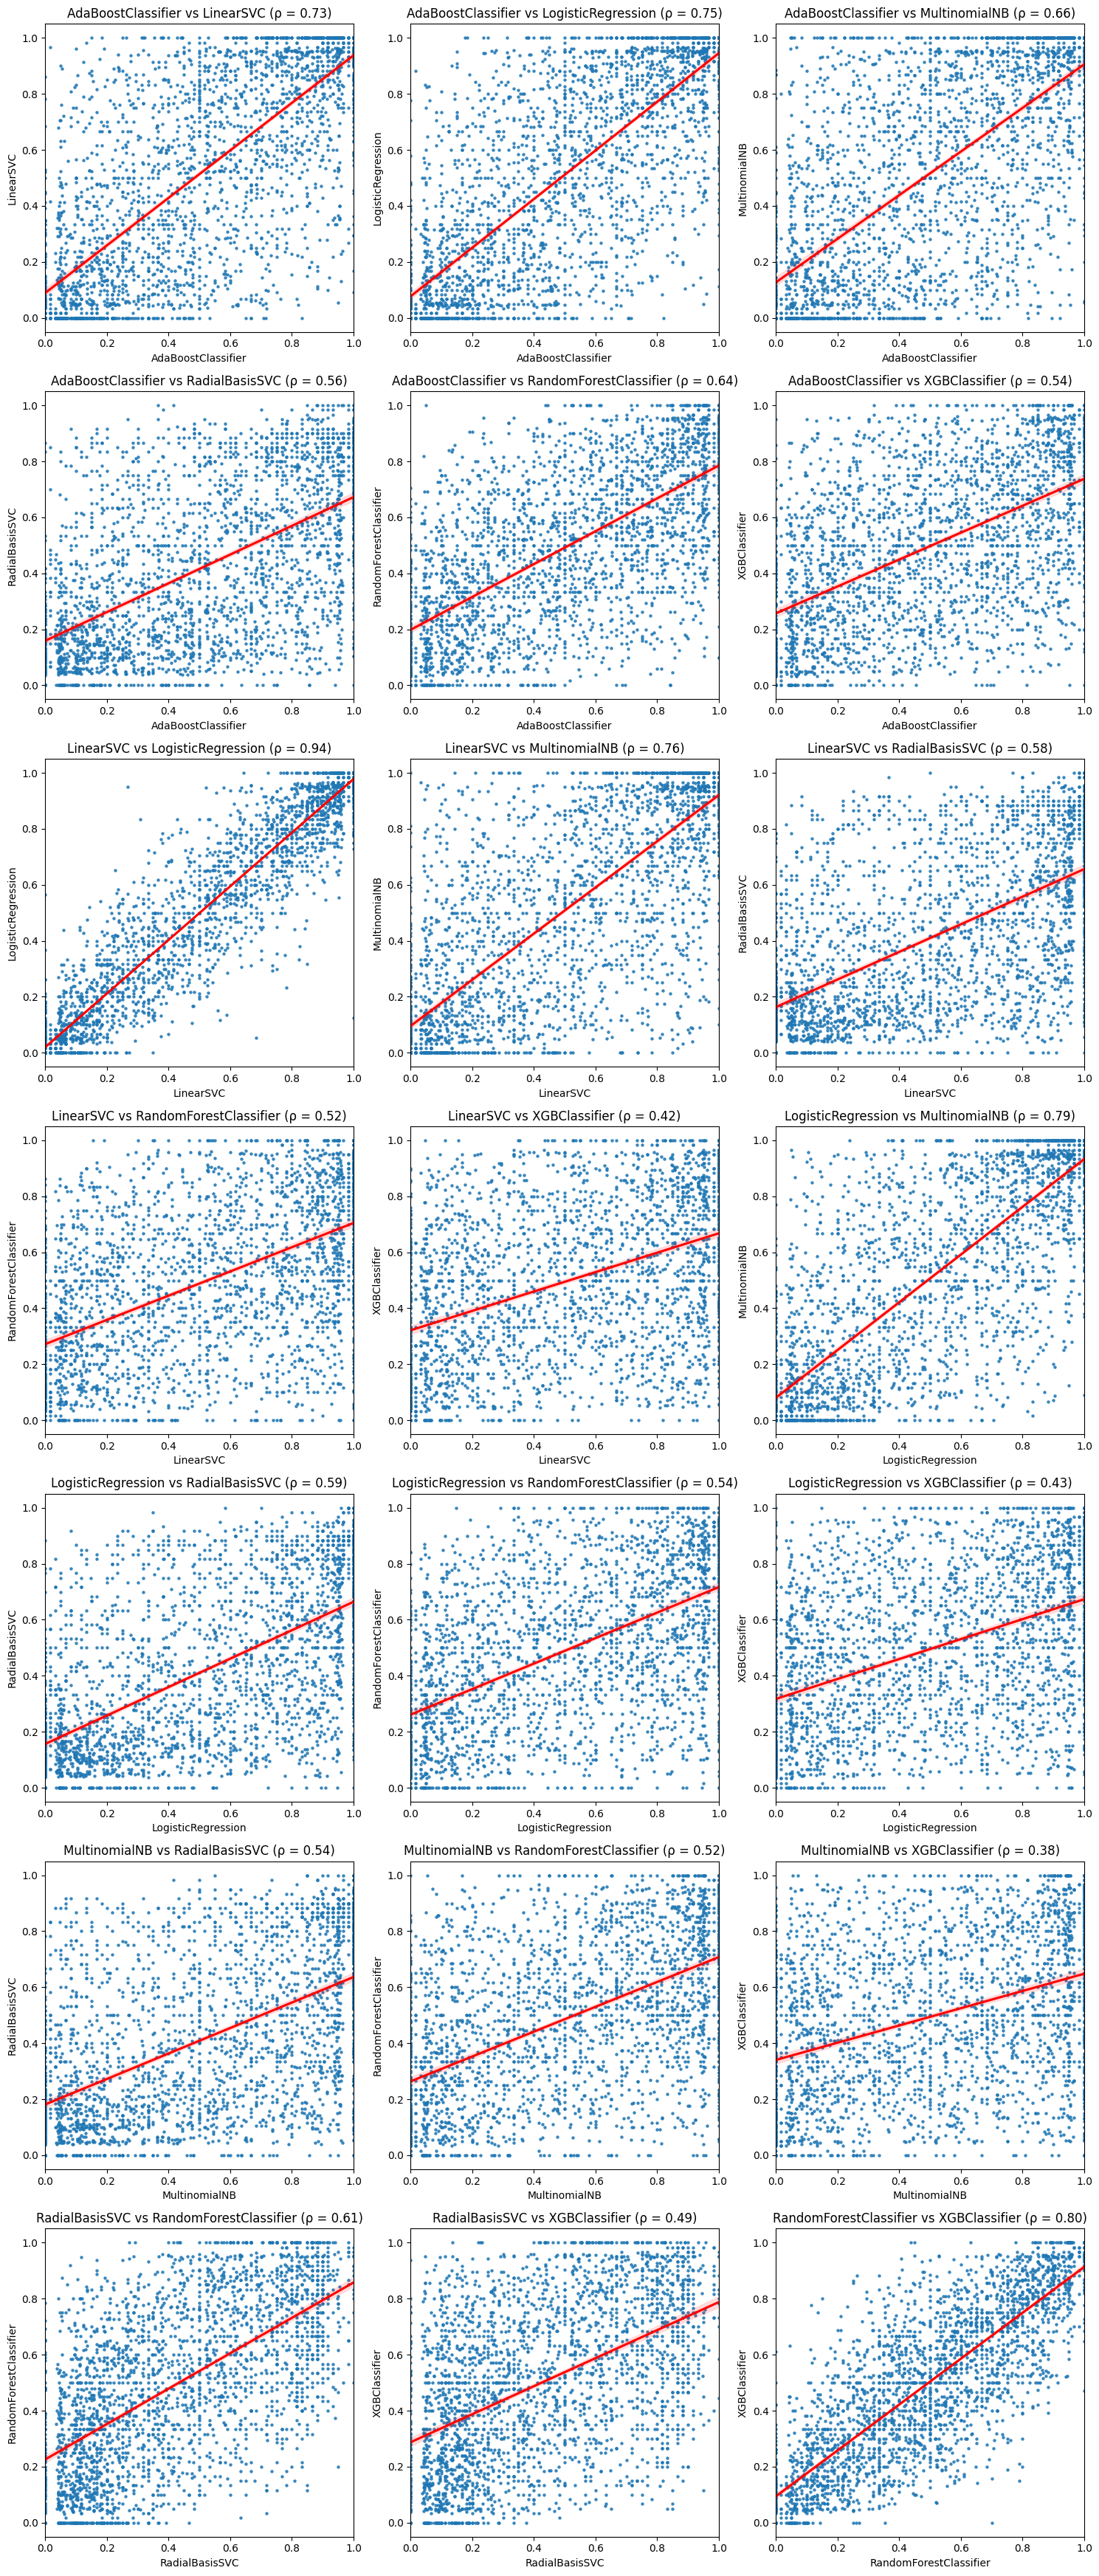

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Assuming that model_control_accuracy_pivot_df is your DataFrame
df = model_accuracy_pivot_df

models = df.columns
model_pairs = list(itertools.combinations(models, 2))

# Calculate the number of subplots needed
n = len(model_pairs)
ncols = 3  # number of columns of subplots
nrows = n // ncols + (n % ncols > 0)  # number of rows of subplots

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*5))

# Flattening the axes, so it's easier to iterate through them
axes = axes.flatten()

# Iterate through each pair of models and plot the scatterplot
for pair, ax in zip(model_pairs, axes):
    sns.regplot(x=pair[0], y=pair[1], data=df, ax=ax, 
                scatter_kws={'s':5}, 
                line_kws={'color':'red'}, 
                robust=True)
    
    # Calculate Spearman correlation
    corr = df[[pair[0], pair[1]]].corr(method='spearman').iloc[0,1]
    ax.set_title(f'{pair[0]} vs {pair[1]} (ρ = {corr:.2f})')

# Delete any unused subplots
for i in range(len(model_pairs), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


## Plot heatmap of variants x cases and variants x controls

- Sort samples by accuracy 
- Color by feature value
    - Cluster case variants, show dendogram
    - Order control variants by case clustering too

## View variants by sample accuracy

In [ ]:
accurateCases

In [ ]:
accurateCaseEmbeddings

In [ ]:
topVariants

In [ ]:
outlierCaseEmbeddings.index

In [ ]:
import dash_bio

accurateCases = accurateSamples.loc[accurateSamples['label'] == 1].sort_values(by=['accuracy'], ascending=False).set_index('id', drop=True)
accurateCaseEmbeddings = embedding.loc[embedding.index.isin(accurateCases.index)].reindex(accurateCases.index)
accurateControls = accurateSamples.loc[accurateSamples['label'] == 0].sort_values(by=['accuracy'], ascending=False).set_index('id', drop=True)
accurateControlEmbeddings = embedding.loc[embedding.index.isin(accurateControls.index)].reindex(accurateControls.index)

discordantCases = discordantSamples.loc[discordantSamples['label'] == 1].sort_values(by=['accuracy'], ascending=False).set_index('id', drop=True)
discordantCaseEmbeddings = embedding.loc[embedding.index.isin(discordantCases.index)].reindex(discordantCases.index)
discordantControls = discordantSamples.loc[discordantSamples['label'] == 0].sort_values(by=['accuracy'], ascending=False).set_index('id', drop=True)
discordantControlEmbeddings = embedding.loc[embedding.index.isin(discordantControls.index)].reindex(discordantControls.index)

outlierCases = pd.concat([accurateCases, discordantCases]).sort_values(by=['accuracy'], ascending=False)
outlierCaseEmbeddings = embedding.loc[embedding.index.isin(outlierCases.index)].reindex(outlierCases.index)

outlierControls = pd.concat([accurateControls, discordantControls]).sort_values(by=['accuracy'], ascending=False)
outlierControlEmbeddings = embedding.loc[embedding.index.isin(outlierControls.index)].reindex(outlierControls.index)

outlierSamples = pd.concat([accurateSamples, discordantSamples]).sort_values(by=['accuracy'], ascending=False)
outlierEmbeddings = embedding.loc[embedding.index.isin(outlierSamples.index)].reindex(outlierSamples.index)

topVariants = averageCaseGlobalFeatureImportances.iloc[:10].index
outlierCaseEmbeddings = outlierCaseEmbeddings[topVariants]
outlierControlEmbeddings = outlierControlEmbeddings[topVariants]


plot = dash_bio.Clustergram(
    data=outlierCaseEmbeddings.T.values,
    row_labels=list(outlierCaseEmbeddings.columns.values),
    column_labels=list(outlierCaseEmbeddings.index),
    hidden_labels='column',
    cluster='row',
    height=1200,
    width=1200,
    color_map= [
        [0.0, '#636EFA'],
        [0.25, '#AB63FA'],
        [0.5, '#FFFFFF'],
        [0.75, '#E763FA'],
        [1.0, '#EF553B']
    ])
plot.update_layout(title={'text': 'Outlier Case Variants (Accuracy >= 85% or <= 15%, highest on left)', 'x': 0.5, 'xanchor': 'center'})
plot.write_html('outlier_cases_clustergram.html')

# TODO filter important variants 
plot = dash_bio.Clustergram(
    data=outlierControlEmbeddings.T.values,
    row_labels=list(outlierControlEmbeddings.columns.values),
    column_labels=list(outlierControlEmbeddings.index),
    hidden_labels='column',
    cluster='row',
    height=1200,
    width=1200,
    color_map= [
        [0.0, '#636EFA'],
        [0.25, '#AB63FA'],
        [0.5, '#FFFFFF'],
        [0.75, '#E763FA'],
        [1.0, '#EF553B']
    ])
plot.update_layout(title={'text': 'Outlier Control Variants (Accuracy >= 85% or <= 15%, highest on left)', 'x': 0.5, 'xanchor': 'center'})
plot.write_html('outlier_controls_clustergram.html')

plot = dash_bio.Clustergram(
    data=embedding.T.values,
    row_labels=list(embedding.columns.values),
    column_labels=list(embedding.index),
    hidden_labels='column',
    cluster='row',
    height=1200,
    width=1200,
    color_map= [
        [0.0, '#636EFA'],
        [0.25, '#AB63FA'],
        [0.5, '#FFFFFF'],
        [0.75, '#E763FA'],
        [1.0, '#EF553B']
    ])
plot.update_layout(title={'text': 'Outlier Case & Control Variants (Accuracy >= 85% or <= 15%, highest on left)', 'x': 0.5, 'xanchor': 'center'})
plot.write_html('outliers_clustergram.html')

In [ ]:

plot = dash_bio.Clustergram(
    data=discordantCaseEmbeddings.T.values,
    row_labels=list(discordantCaseEmbeddings.columns.values),
    column_labels=list(discordantCaseEmbeddings.index),
    hidden_labels='column',
    cluster='row',
    height=1200,
    width=1200,
    color_map= [
        [0.0, '#636EFA'],
        [0.25, '#AB63FA'],
        [0.5, '#FFFFFF'],
        [0.75, '#E763FA'],
        [1.0, '#EF553B']
    ])
plot.update_layout(title={'text': 'Discordant Case Variants (Accuracy <= 15%, highest on left)', 'x': 0.5, 'xanchor': 'center'})
plot.write_html('discordant_cases_clustergram.html')

plot = dash_bio.Clustergram(
    data=discordantControlEmbeddings.T.values,
    row_labels=list(discordantControlEmbeddings.columns.values),
    column_labels=list(discordantControlEmbeddings.index),
    hidden_labels='column',
    cluster='row',
    height=1200,
    width=1200,
    color_map= [
        [0.0, '#636EFA'],
        [0.25, '#AB63FA'],
        [0.5, '#FFFFFF'],
        [0.75, '#E763FA'],
        [1.0, '#EF553B']
    ])
plot.update_layout(title={'text': 'Discordant Control Variants (Accuracy <= 15%, highest on left)', 'x': 0.5, 'xanchor': 'center'})
plot.write_html('discordant_controls_clustergram.html')


In [ ]:
accurateCaseEmbeddings


## Find patients that have top variants based on model coefficients

### locally-tracked files

In [ ]:
import os

bootstrapPath = f"../src/{config['project']}/bootstraps"
bootstrapDirs = os.listdir(bootstrapPath)
bootstrapDirs = [int(bootstrapDir) for bootstrapDir in bootstrapDirs]
bootstrapDirs.sort()

modelCoefficientsDir = f"../src/{config['project']}/averageModelCoefficients"
modelCoefficientsFiles = os.listdir(modelCoefficientsDir)

In [ ]:
import pandas as pd
import numpy as np

def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

generallyImportantAverage = pd.DataFrame()
caseImportanceAverage = pd.DataFrame()
controlImportanceAverage = pd.DataFrame()

for modelCoefficientFile in modelCoefficientsFiles:
    modelCoefficientDF = pd.read_csv(f"{modelCoefficientsDir}/{modelCoefficientFile}")
    model_name = modelCoefficientFile.split('.')[0]
    
    if "feature_importances_control" in modelCoefficientDF.columns and ("feature_importances" in modelCoefficientDF.columns 
        or 'feature_importances_case' in modelCoefficientDF.columns
    ):        
            
        if "feature_importances" in modelCoefficientDF.columns and not (modelCoefficientDF['feature_importances_control'].abs() == modelCoefficientDF['feature_importances'].abs()).all():
            modelCoefficientDF['feature_importances_control'] = min_max_normalize(modelCoefficientDF['feature_importances_control'])
            modelCoefficientDF['feature_importances'] = min_max_normalize(modelCoefficientDF['feature_importances'])
            modelCoefficientDF = modelCoefficientDF.rename(columns={'feature_importances_control': f"{model_name}_control_importance", 'feature_importances': f"{model_name}_case_importance"})
       
        if 'feature_importances_case' in modelCoefficientDF.columns and not (modelCoefficientDF['feature_importances_control'].abs() == modelCoefficientDF['feature_importances_case'].abs()).all():
            modelCoefficientDF['feature_importances_case'] = min_max_normalize(modelCoefficientDF['feature_importances_case'])
            modelCoefficientDF['feature_importances_control'] = min_max_normalize(modelCoefficientDF['feature_importances_control'])
            modelCoefficientDF = modelCoefficientDF.rename(columns={'feature_importances_case': f"{model_name}_case_importance", 'feature_importances_control': f"{model_name}_control_importance"})
       
        else: 
            # drop redundant values
            modelCoefficientDF = modelCoefficientDF.drop(columns=['feature_importances_control'])
            modelCoefficientDF = modelCoefficientDF.rename(columns={('feature_importances_case' if 'feature_importances_case' in modelCoefficientDF else 'feature_importances'): f"{model_name}_importance"})
            modelCoefficientDF[f"{model_name}_importance"] = min_max_normalize(modelCoefficientDF[f"{model_name}_importance"])
            generallyImportantAverage = pd.concat([generallyImportantAverage, modelCoefficientDF.set_index('features')[f"{model_name}_importance"]], axis=1)
            continue

        controlImportanceAverage = pd.concat([controlImportanceAverage, modelCoefficientDF.set_index('features')[f"{model_name}_control_importance"]], axis=1)
        caseImportanceAverage = pd.concat([caseImportanceAverage, modelCoefficientDF.set_index('features')[f"{model_name}_case_importance"]], axis=1)
   
    modelCoefficientDF = modelCoefficientDF.rename(columns={'feature_importances': f"{model_name}_importance"})
    modelCoefficientDF[f"{model_name}_importance"] = min_max_normalize(modelCoefficientDF[f"{model_name}_importance"])
    generallyImportantAverage = pd.concat([generallyImportantAverage, modelCoefficientDF.set_index('features')[f"{model_name}_importance"]], axis=1)

# Calculate means and standard deviations before sorting
# The standard deviations should be ordered in the same way as the averages

# Create a new DataFrame to store averages
generallyImportantAverage_numeric = pd.DataFrame(index=generallyImportantAverage.index)
caseImportanceAverage_numeric = pd.DataFrame(index=caseImportanceAverage.index)
controlImportanceAverage_numeric = pd.DataFrame(index=controlImportanceAverage.index)

# Iterate over each column
for col in generallyImportantAverage.columns:
    # Check if column is numeric
    if np.issubdtype(generallyImportantAverage[col].dtypes, np.number):
        # Calculate mean and standard deviation
        generallyImportantAverage['mean'] = generallyImportantAverage.mean(axis=1)
        generallyImportantAverage['std'] = generallyImportantAverage.std(axis=1)

for col in caseImportanceAverage.columns:
    # Check if column is numeric
    if np.issubdtype(caseImportanceAverage[col].dtypes, np.number):
        # Calculate mean and standard deviation
        caseImportanceAverage['mean'] = caseImportanceAverage.mean(axis=1)
        caseImportanceAverage['std'] = caseImportanceAverage.std(axis=1)

for col in controlImportanceAverage.columns:
    # Check if column is numeric
    if np.issubdtype(controlImportanceAverage[col].dtypes, np.number):
        # Calculate mean and standard deviation
        controlImportanceAverage['mean'] = controlImportanceAverage.mean(axis=1)
        controlImportanceAverage['std'] = controlImportanceAverage.std(axis=1)


# Concatenate original dataframes with statistics dataframes
generallyImportantMerged = pd.concat([generallyImportantAverage, generallyImportantAverage_numeric], axis=1)
caseImportanceMerged = pd.concat([caseImportanceAverage, caseImportanceAverage_numeric], axis=1)
controlImportanceMerged = pd.concat([controlImportanceAverage, controlImportanceAverage_numeric], axis=1)


In [ ]:
import plotly.graph_objects as go

# Your dataframes
dataframes = [generallyImportantMerged, caseImportanceMerged, controlImportanceMerged]
names = ['ALS Generally Important Parameters', 'ALS Case-important Parameters — Multinomial Naive Bayes', 'ALS Control-important Parameters — Multinomial Naive Bayes']

# For each dataframe
for df, name in zip(dataframes, names):
    # Create a new Figure
    fig = go.Figure()
    
    df = df.sort_values(by='mean', ascending=False)
    color = 'blue' if 'case' in name.lower() else 'red' if 'control' in name.lower() else None
    # For each model
    for model in df.columns:
        if "importance" in model:
            fig.add_trace(go.Bar(
                name=model.split('_')[0],  # Model name
                x=df.index,  # Features
                y=df[model],  # Importance
                error_y=dict(
                    type='data',  # The errors are data not a percentage
                    array=df["std"],  # Std
                    visible=True
                ),
                marker_color=color  # Color
            ))

    # Update the layout and show the figure
    fig.update_layout(
        barmode='group',  # Grouped bar chart
        title=name,  # Title
        yaxis_title='Importance',  # y-axis label
        xaxis=dict(
            tickangle=45,  # adjust as needed
            title='Features',
            titlefont_size=16,
            tickfont_size=9,  # decrease font size if needed
        ),
    )
    fig.show()
    fig.write_html(f"{name}.html")


In [ ]:
def plot_feature_importance(df, df_std, title, color):
    fig = go.Figure(data=[go.Bar(
        x=df.index,
        y=df.values,
        error_y=dict(type='data', array=df_std, visible=True),
        text=df.values.round(2),
        textposition='auto',
        marker_color=color
    )])
    
    # Create custom tick positions and labels
    tickvals = list(range(len(df.index)))
    ticktext = df.index.tolist()

    fig.update_layout(
        title_text=title,
        bargap=0.2,
        xaxis=dict(
            tickmode='array',
            tickvals=tickvals,
            ticktext=ticktext,
            tickangle=45,  # adjust as needed
            title='Features',
            titlefont_size=16,
            tickfont_size=9,  # decrease font size if needed
        ),
        yaxis=dict(
            title='Feature Importance',
            titlefont_size=16,
            tickfont_size=14,
        ),
    )
    fig.show()

# Pass both the averages and standard deviations to the plotting function
generallyImportantSortedMean = generallyImportantMerged.sort_values(by='mean', ascending=False, )
plot_feature_importance(generallyImportantSortedMean['mean'], generallyImportantSortedMean['std'], "ALS Generally Important Averaged Model Parameters — Sorted by average", 'green')

generallyImportantSortedStd = generallyImportantMerged.sort_values(by='std', ascending=True)
plot_feature_importance(generallyImportantSortedStd['mean'], generallyImportantSortedStd['std'], "ALS Generally Important Averaged Model Parameters — Sorted by 1 standard deviation", 'green')


In [ ]:
import plotly.graph_objects as go

# Example data
features = generallyImportantAverage.index
general_values = generallyImportantAverage.values
case_values = caseImportanceAverage.values
control_values = controlImportanceAverage.values

general_error = generallyImportantStd.values
case_error = caseImportanceStd.values
control_error = controlImportanceStd.values

# Create traces
trace_general = go.Bar(
    x=features,
    y=general_values,
    name='General',
    error_y=dict(type='data', array=general_error, visible=True)
)

trace_case = go.Bar(
    x=features,
    y=case_values,
    name='Case',
    error_y=dict(type='data', array=case_error, visible=True)
)

trace_control = go.Bar(
    x=features,
    y=control_values,
    name='Control',
    error_y=dict(type='data', array=control_error, visible=True)
)

# Create layout
layout = go.Layout(
    title='Feature Importance Comparison',
    barmode='group',
    autosize=False,
    width=800,
    height=500,
    xaxis=dict(
        title='Features',
        tickangle=45,
        titlefont_size=16,
        tickfont_size=9,
    ),
    yaxis=dict(
        title='Feature Importance',
        titlefont_size=16,
        tickfont_size=14,
    ),
)

# Create figure and add traces
fig = go.Figure(data=[trace_general, trace_case, trace_control], layout=layout)

# Show plot
fig.show()


In [ ]:
topGeneralVariants = generallyImportantAverage.sort_values(ascending=False).iloc[:10]
topGeneralVariantEmbeddings = embedding.loc[:,topGeneralVariants.index]
topGeneralVariantEmbeddings.index = embedding['Unnamed: 0']
topGeneralVariantEmbeddings.index.name = 'id'

topCaseVariantEmbeddings = caseImportanceAverage.sort_values(ascending=False).iloc[:10]
topControlVariantEmbeddings = caseImportanceAverage.sort_values(ascending=False).iloc[:-10]
topCaseVariantEmbeddings = embedding.loc[:]

In [ ]:
def get_sample_ids_all_minor(df):
    return df[df.eq(1).all(axis=1)].index.tolist()

topGeneralVariantSampleIds_all_minor = get_sample_ids_all_minor(topGeneralVariantEmbeddings)
topCaseVariantSampleIds_all_minor = get_sample_ids_all_minor(topCaseVariantEmbeddings)
topControlVariantSampleIds_all_minor = get_sample_ids_all_minor(topControlVariantEmbeddings)

# Printing results
print("Sample IDs for top general variants (all minor alleles):", topGeneralVariantSampleIds_all_minor)
print("Sample IDs for top case variants (all minor alleles):", topCaseVariantSampleIds_all_minor)
print("Sample IDs for top control variants (all minor alleles):", topControlVariantSampleIds_all_minor)


In [ ]:
import pandas as pd

def write_to_csv(sample_ids, filename):
    series = pd.Series(sample_ids)
    series.to_csv(filename, index=False)

write_to_csv(topGeneralVariantSampleIds_all_minor, "topGeneralVariantSampleIds_all_minor.csv")
write_to_csv(topCaseVariantSampleIds_all_minor, "topCaseVariantSampleIds_all_minor.csv")
write_to_csv(topControlVariantSampleIds_all_minor, "topControlVariantSampleIds_all_minor.csv")

In [ ]:
embedding

## Shapely value distribution for well-classified samples

In [ ]:
def serialize_sample_shap(sampleValues):
    # some models only have probabilities for a single class
    return sampleValues.values[:,1] if len(sampleValues.values.shape) > 1 else sampleValues.values

serializedData = []
for sampleValues in accurateSamples['shapExplanations']:
    serializedData.append(serialize_sample_shap(sampleValues))
    
shapelyValueDataframe = pd.DataFrame(serializedData, columns=accurateSamples.iloc[0]['shapExplanations'].feature_names)
shapelyValueDataframe.index = accurateSamples['id']

In [ ]:
accurateSamples['shapExplanations'].iloc[0].values[0]

In [ ]:
shapelyValueDataframe

In [ ]:
import numpy as np
import plotly.express as px

df_stats = shapelyValueDataframe.describe().T

# Create a DataFrame for the plotting
df_plot_mean = df_stats[['mean']].reset_index()
df_plot_std = df_stats[['std']].reset_index()

# Sort by the greatest mean Shapley value and least standard deviation
df_plot_mean = df_plot_mean.sort_values(['mean'], ascending=False)
df_plot_std = df_plot_std.sort_values(['std'], ascending=True)

# Create a bar chart for means
fig_mean = px.bar(df_plot_mean, x='index', y='mean', labels={'index':'Feature', 'mean':'Mean Shapely Value'})
fig_mean.show()

# Create a bar chart for standard deviations
fig_std = px.bar(df_plot_std, x='index', y='std', labels={'index':'Feature', 'std':'Standard Deviation'})
fig_std.show()


In [ ]:
df_stats[['mean', 'std']].corr(method='pearson')

In [ ]:
accurateCases = [id for id in accurateSamples['id'].unique() if "CTR" not in id]
pd.Series(accurateCases, name='id').to_csv('accurateCases.csv', index=False)

In [ ]:
discordantSampleIDs = discordantSamples['id'].unique()
discordantCases = [id for id in discordantSampleIDs if "CTR" not in id]
pd.Series(discordantCases, name='id').to_csv('discordantCases.csv', index=False)

In [ ]:
discordantSampleIDs